# Computer vision
It is the art of teaching a computer to see

#### What we are going to cover

<img src="img/04-computer-vision.png" alt="drawing" width="1000"/>

### important computer vision libraries
![img1](img/04-libraries.png)

In [64]:
import torch
from torch import nn
from torch.utils.data import DataLoader

# Computer vision libraries
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# for model evaluation
from torchmetrics import F1Score, Accuracy

# for visualization
import matplotlib.pyplot as plt

# for time measuring
from timeit import default_timer as timer

# for progress bar
from tqdm.auto import tqdm

# agnostic code
device = "cuda:0" if torch.cuda.is_available() else "cpu"

print(f'Current device is {device}')
print('PyTorch version is', torch.__version__)
print('torchvision version is', torchvision.__version__)

Current device is cpu
PyTorch version is 1.12.1+cu102
torchvision version is 0.13.1+cu102


In [42]:
def print_train_time(start, end, device):
     """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
     total_number = end - start
     print(f"Train time on {device} is {total_number:.3f} seconds")
     return total_number

In [106]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               score_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        score_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, score = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_predicted = model(X)
            y_predicted_labels = y_predicted.argmax(dim=1)
            loss += loss_fn(y_predicted, y)
            score += score_fn(y_predicted_labels, y)
        loss /= len(data_loader)
        score /= len(data_loader)
    d = {'model_name': model.__class__.__name__,
         'model_loss': loss.item(),
         'model_score': score}
    return d

# 1. Dataset

In [3]:
train_data = datasets.FashionMNIST(root='data',
                                   train=True,
                                   transform=ToTensor(),
                                   target_transform=None)

test_data = datasets.FashionMNIST(root='data',
                                  train=False,
                                  transform=ToTensor())

print(f'train: {train_data}\n\ntest: {test_data}')

train: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

test: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
type(train_data)

torchvision.datasets.mnist.FashionMNIST

In [12]:
# see example
print(f'type of element is {type(train_data[15])}')
print(f'feature shape is {train_data[15][0].shape}')
print(f'label {train_data[15][1]}')

type of element is <class 'tuple'>
feature shape is torch.Size([1, 28, 28])
label 9


**color_channels = 1, height = 28, weight = 28**

![img2](img/04-input-output-shapes.png)

PyTorch generally accepts `NCHW` format (channels first) as the default. But `NHWC` format (channels last) performs **better** and it is considered as **the best practice**

In [13]:
print('classes:', train_data.classes)

classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


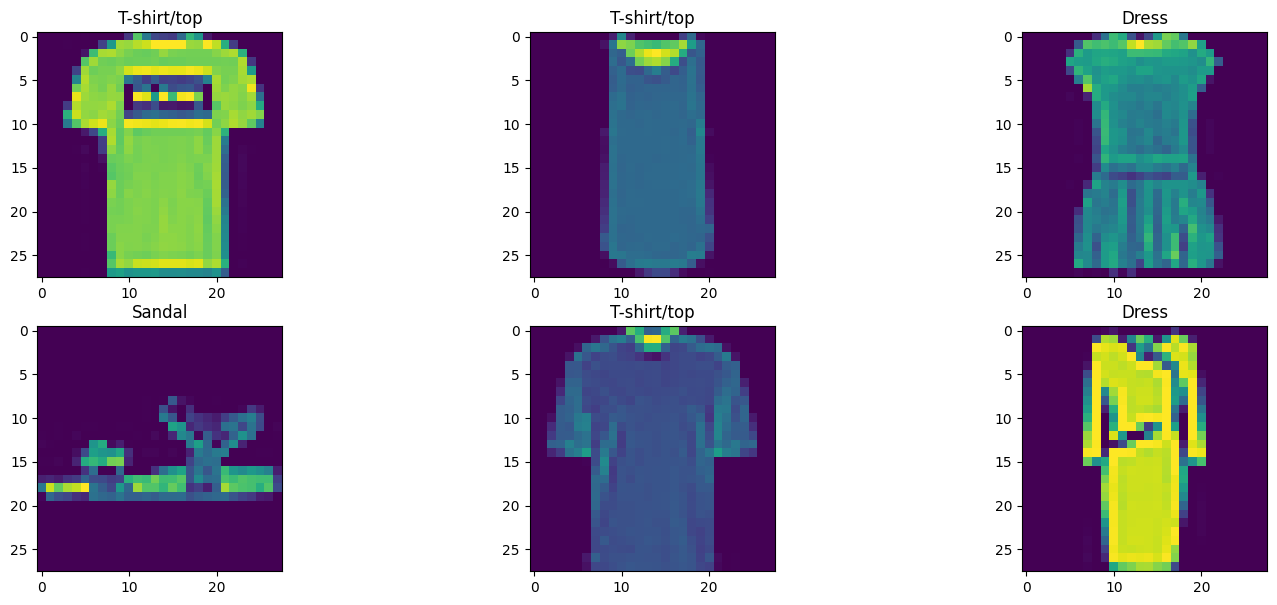

In [24]:
plt.figure(figsize=(18, 7))
for i in range(1, 4):
    image, label = train_data[i]
    plt.subplot(2, 3, i)
    plt.imshow(image.squeeze())
    plt.title(train_data.classes[label])

    image, label = train_data[-i]
    plt.subplot(2, 3, i+3)
    plt.imshow(image.squeeze())
    plt.title(train_data.classes[label])

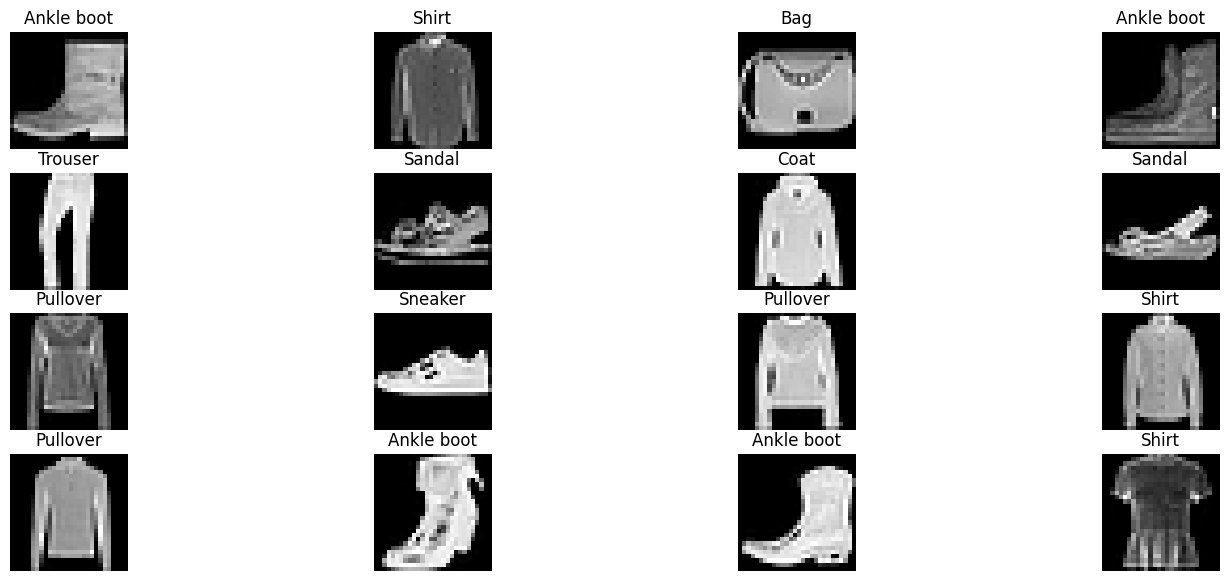

In [26]:
torch.manual_seed(42)
fig = plt.figure(figsize=(18, 7))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_index = torch.randint(low=0,
                                 high=len(train_data),
                                 size=[1]).item()
    image, label = train_data[random_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(train_data.classes[label])
    plt.axis(False)

# 2. Prepare Dataset
`DataLoader` helps load data into a model. It turns `Dataset` into iterable of chunks that are called **batches**. It's more efficient to use batches (really large datasets contain a lot of objects so it important to break data into batches)

In [31]:
# it is hyperparameter (32, 64, 128, 256, 512, ...)
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)

test_dataloader = DataLoader(dataset=test_data,
                              shuffle=False,
                              batch_size=BATCH_SIZE)

print(f'Dataloaders:\n'
      f'-train: {len(train_dataloader)} batches\n'
      f'-test: {len(test_dataloader)} batches')
print(f'Each batch contains {BATCH_SIZE} objects')

Dataloaders:
-train: 1875 batches
-test: 313 batches
Each batch contains 32 objects


In [32]:
# let see on the batch
example_features, example_labels = next(iter(train_dataloader))
print(example_features.shape, example_labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


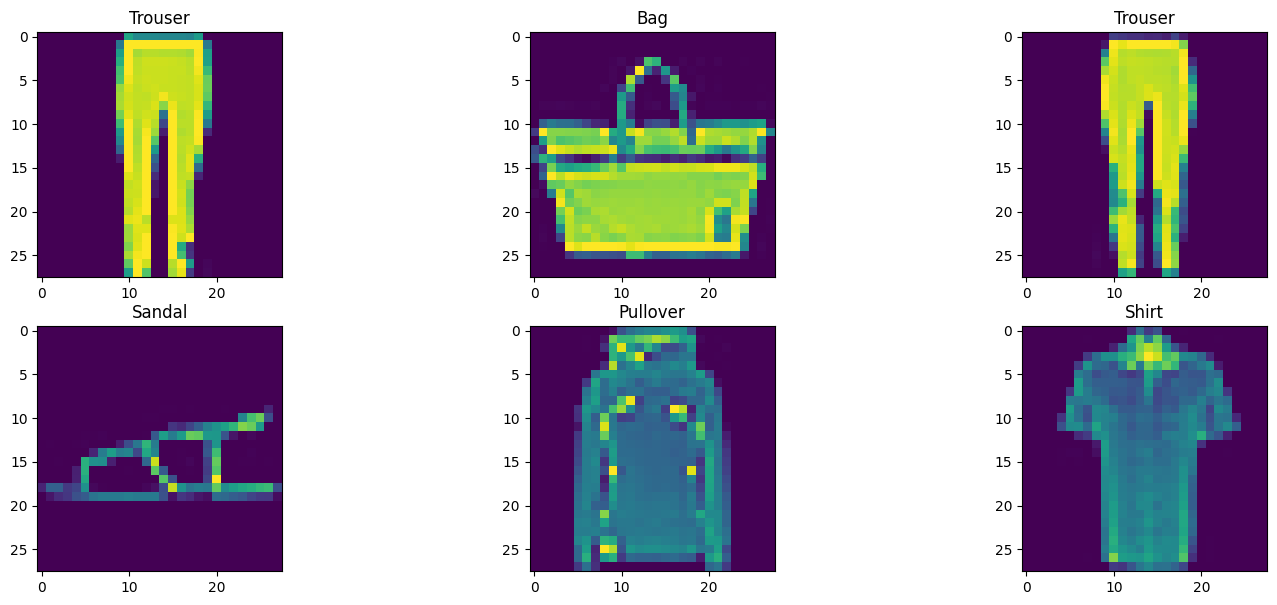

In [33]:
torch.manual_seed(0)
rows = 2
cols = 3
fig = plt.figure(figsize=(18, 7))
for i in range(1, rows*cols + 1):
    image = example_features[i]
    label = example_labels[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze())
    plt.title(train_data.classes[label])

# 3. Baseline model

In [54]:
class FashionModelV0(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Flatten(), # network prefer data in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layers_stack(x)

In [86]:
model_v0 = FashionModelV0(
    input_shape=1*28*28, # image (features) shape
    output_shape=10, # classes
    hidden_units=100,
    ).to(device=device)
model_v0

FashionModelV0(
  (layers_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [87]:
# check an output
model_v0(train_dataloader.dataset[0][0]).shape

torch.Size([1, 10])

In [88]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_v0.parameters(),
                             lr=0.1)
f1_metric = F1Score(num_classes=10)
accuracy_metric = Accuracy(num_classes=10)

#### How our model will train?
1. Loop through epochs (each epoch model run the whole train data)
2. Loop through training batches
    2.1 calculate train loss per batch
    2.2 optimizer step per batch
3. Loop through testing batches
    2.1 calculate test loss per batch
    2.2 calculate metric per batch
4. Print what's happening each `n`th epoch
5. TIme it (fun)

In [89]:
torch.manual_seed(42)
train_time_start = timer()
epochs = 5

for epoch in tqdm(range(1, epochs+1)):
    print(f'Epoch {epoch} / {epochs} ----------')

    train_loss_epoch = 0
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        model_v0.train()
        y_pred = model_v0(X_train)
        train_loss_batch = loss_fn(y_pred, y_train)
        train_loss_epoch += train_loss_batch

        optimizer.zero_grad()
        train_loss_batch.backward()
        optimizer.step()

        if batch % 500 == 0:
            print(f'we saw {batch * len(X_train)}/{len(train_dataloader.dataset)} samples')

    # average
    train_loss_epoch = train_loss_epoch / len(train_dataloader)

    test_loss_epoch, score_test_epoch = 0.0, 0.0
    model_v0.eval()
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            y_pred = model_v0(X_test)
            y_pred_labels = y_pred.argmax(dim=1)
            loss_test_batch = loss_fn(y_pred, y_test)
            score_test_batch = f1_metric(y_test, y_pred_labels)
            test_loss_epoch += loss_test_batch
            score_test_epoch += score_test_batch

        test_loss_epoch /= len(test_dataloader)
        score_test_epoch /= len(test_dataloader)

    print(f'Train loss: {train_loss_epoch:.5f}\n'
          f'Test loss: {test_loss_epoch:.5f}\n'
          f'Test F1-score: {score_test_epoch:.5f}')
train_time_end = timer()
total_time = print_train_time(start=train_time_start,
                              end=train_time_end,
                              device=str(next(model_v0.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 / 5 ----------
we saw 0/60000 samples
we saw 16000/60000 samples
we saw 32000/60000 samples
we saw 48000/60000 samples
Train loss: 0.57876
Test loss: 0.49986
Test F1-score: 0.82518
Epoch 2 / 5 ----------
we saw 0/60000 samples
we saw 16000/60000 samples
we saw 32000/60000 samples
we saw 48000/60000 samples
Train loss: 0.47449
Test loss: 0.48348
Test F1-score: 0.82957
Epoch 3 / 5 ----------
we saw 0/60000 samples
we saw 16000/60000 samples
we saw 32000/60000 samples
we saw 48000/60000 samples
Train loss: 0.45404
Test loss: 0.47741
Test F1-score: 0.83496
Epoch 4 / 5 ----------
we saw 0/60000 samples
we saw 16000/60000 samples
we saw 32000/60000 samples
we saw 48000/60000 samples
Train loss: 0.44184
Test loss: 0.46244
Test F1-score: 0.83706
Epoch 5 / 5 ----------
we saw 0/60000 samples
we saw 16000/60000 samples
we saw 32000/60000 samples
we saw 48000/60000 samples
Train loss: 0.43538
Test loss: 0.46815
Test F1-score: 0.83287
Train time on cpu is 21.764 seconds


In [90]:
results_v0 = eval_model(model=model_v0,
                        data_loader=test_dataloader,
                        loss_fn=loss_fn,
                        score_fn=accuracy_metric)
results_v0

{'model_name': 'FashionModelV0',
 'model_loss': 0.4681464731693268,
 'model_score': tensor(0.8329)}

# 4. Build a better model with non-linearity

In [91]:
class FashionModelV1(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.layers_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100,
                      out_features=50),
            nn.Softplus(),
            nn.Linear(in_features=50,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layers_stack(x)

In [100]:
model_v1 = FashionModelV1(input_shape=1*28*28,
                          output_shape=10).to(device=device)

In [101]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_v1.parameters(),
                             lr=0.01)

In [102]:
def train_epoch(model, train_loader, loss_function, eval_function, dev=device):
    loss_train_epoch, score_train_epoch = 0, 0
    for b, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(dev), y_batch.to(dev)
        model.train()

        y_predicted_logits = model(X_batch)
        y_predicted_targets = y_predicted_logits.argmax(dim=1)

        loss_train = loss_function(y_predicted_logits, y_batch)
        score_train = eval_function(y_predicted_targets, y_batch)

        loss_train_epoch += loss_train
        score_train_epoch += score_train

        optimizer.zero_grad()

        loss_train.backward()

        optimizer.step()

    loss_train_epoch /= len(train_loader)
    score_train_epoch /= len(train_loader)
    print('Train set:\n'
          f'* loss = {loss_train_epoch}\n'
          f'* Score = {score_train_epoch}')

In [103]:
def test_epoch(model, test_loader, loss_function, eval_function, dev=device):
    loss_test_epoch, score_test_epoch = 0, 0
    model.eval()
    with torch.inference_mode():
        for b, (X_batch, y_batch) in enumerate(test_loader):
            X_batch, y_batch = X_batch.to(dev), y_batch.to(dev)
            y_predicted_logits = model(X_batch)
            y_predicted_targets = y_predicted_logits.argmax(dim=1)
            loss_test = loss_function(y_predicted_logits, y_batch)
            score_test = eval_function(y_predicted_targets, y_batch)
            loss_test_epoch += loss_test
            score_test_epoch += score_test

        loss_test_epoch /= len(test_loader)
        score_test_epoch /= len(test_loader)
        print('Test set:\n'
             f'* loss = {loss_test_epoch}\n'
             f'* Score = {score_test_epoch}')

In [104]:
train_time_start = timer()

epochs = 5
for epoch in tqdm(range(1, epochs+1)):
    print(f'Epoch {epoch} / {epochs}')
    train_epoch(model=model_v1,
                train_loader=train_dataloader,
                loss_function=loss_fn,
                eval_function=f1_metric)
    test_epoch(model=model_v1,
               test_loader=test_dataloader,
               loss_function=loss_fn,
               eval_function=f1_metric)
train_time_end = timer()
total = print_train_time(start=train_time_start,
                         end=train_time_end,
                         device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 / 5
Train set:
* loss = 0.5292902588844299
* Score = 0.8093166947364807
Test set:
* loss = 0.5348435044288635
* Score = 0.8134983777999878
Epoch 2 / 5
Train set:
* loss = 0.43343573808670044
* Score = 0.8447833061218262
Test set:
* loss = 0.4634687602519989
* Score = 0.8347643613815308
Epoch 3 / 5
Train set:
* loss = 0.40761491656303406
* Score = 0.8544833064079285
Test set:
* loss = 0.4498819410800934
* Score = 0.8450479507446289
Epoch 4 / 5
Train set:
* loss = 0.3909640610218048
* Score = 0.8623499870300293
Test set:
* loss = 0.43264323472976685
* Score = 0.846345841884613
Epoch 5 / 5
Train set:
* loss = 0.38175028562545776
* Score = 0.8665666580200195
Test set:
* loss = 0.4250713884830475
* Score = 0.8552316427230835
Train time on cpu is 37.065 seconds


In [107]:
results_v1 = eval_model(model=model_v1,
                        data_loader=test_dataloader,
                        loss_fn=loss_fn,
                        score_fn=accuracy_metric)
results_v1, results_v0

({'model_name': 'FashionModelV1',
  'model_loss': 0.4250713884830475,
  'model_score': tensor(0.8552)},
 {'model_name': 'FashionModelV0',
  'model_loss': 0.4681464731693268,
  'model_score': tensor(0.8329)})

# 5. Build a Convolution Neural Network (CNN)